In [1]:
# we naturally first need to import torch and torchvision
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from datasets import load_dataset


def get_mnist_dataloaders(mnist_dataset, batch_size: int):
    pytorch_transforms = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

    # Prepare transformation functions
    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    mnist_train = mnist_dataset["train"].with_transform(apply_transforms)
    mnist_test = mnist_dataset["test"].with_transform(apply_transforms)

    # Construct PyTorch dataloaders
    trainloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(mnist_test, batch_size=batch_size)
    return trainloader, testloader


# Download dataset
mnist = load_dataset("ylecun/mnist")

/home/fredrik/.pyenv/versions/3.10.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

mnist

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

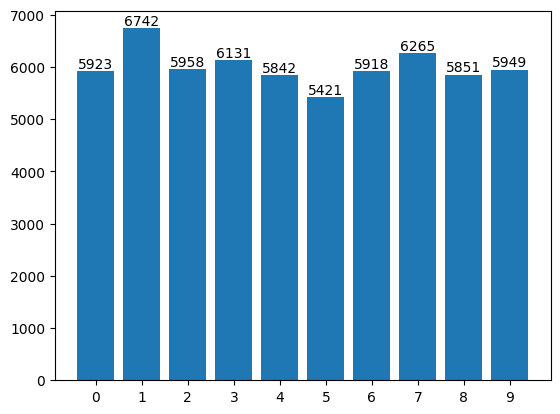

In [3]:
import matplotlib.pyplot as plt
from collections import Counter


# construct histogram
all_labels = mnist["train"]["label"]
all_label_counts = Counter(all_labels)

# visualise histogram
bar = plt.bar(all_label_counts.keys(), all_label_counts.values())
_ = plt.bar_label(bar)

# plot formatting
_ = plt.xticks([label for label in all_label_counts.keys()])
     

In [4]:
import random
import numpy as np
from PIL import Image
import io


def visualise_n_random_examples(trainset_, n: int, verbose: bool = True):
    trainset_data = [
        Image.open(io.BytesIO(entry[0].as_py())) for entry in trainset_.data[0]
    ]
    idx = list(range(len(trainset_data)))
    random.shuffle(idx)
    idx = idx[:n]
    if verbose:
        print(f"will display images with idx: {idx}")

    # construct canvas
    num_cols = 8
    num_rows = int(np.ceil(len(idx) / num_cols))
    fig, axs = plt.subplots(figsize=(16, num_rows * 2), nrows=num_rows, ncols=num_cols)

    # display images on canvas
    for c_i, i in enumerate(idx):
        axs.flat[c_i].imshow(trainset_data[i], cmap="gray")
     

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
model = Net(num_classes=10)
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 44426


In [7]:
def train(net, trainloader, optimizer, device="cpu"):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.to(device)
    net.train()
    for batch in trainloader:
        images, labels = batch["image"].to(device), batch["label"].to(device)
        optimizer.zero_grad()
        loss = criterion(net(images), labels)
        loss.backward()
        optimizer.step()


def test(net, testloader, device):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.to(device)
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(device), batch["label"].to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy


def run_centralised(
    trainloader, testloader, epochs: int, lr: float, momentum: float = 0.9
):
    """A minimal (but complete) training loop"""

    # instantiate the model
    model = Net(num_classes=10)

    # Discover device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # define optimiser with hyperparameters supplied
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # train for the specified number of epochs
    for e in range(epochs):
        print(f"Training epoch {e} ...")
        train(model, trainloader, optim, device)

    # training is completed, then evaluate model on the test set
    loss, accuracy = test(model, testloader, device)
    print(f"{loss = }")
    print(f"{accuracy = }")

In [8]:
# Construct dataloaders
trainloader, testloader = get_mnist_dataloaders(mnist, batch_size=32)

# Run the centralised training
#run_centralised(trainloader, testloader, epochs=3, lr=0.01)

In [9]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner

NUM_PARTITIONS = 100

partitioner = IidPartitioner(num_partitions=NUM_PARTITIONS)
# Let's partition the "train" split of the MNIST dataset
# The MNIST dataset will be downloaded if it hasn't been already
fds = FederatedDataset(dataset="ylecun/mnist", partitioners={"train": partitioner})

In [10]:

# We could load a single partition like this
partition_0 = fds.load_partition(0)
partition_0

Dataset({
    features: ['image', 'label'],
    num_rows: 600
})

In [11]:
import ray
ray.init()
print("Ray initialized successfully")


2024-11-20 18:47:37,039	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-20 18:47:38,325	INFO worker.py:1819 -- Started a local Ray instance.


Ray initialized successfully


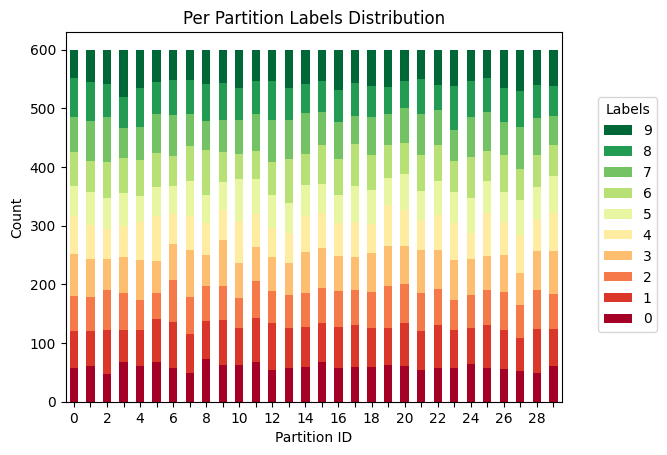

In [12]:
from flwr_datasets.visualization import plot_label_distributions

fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    max_num_partitions=30,  # Note we are only showing the first 30 so the plot remains readable
    title="Per Partition Labels Distribution",
)

In [13]:
from collections import OrderedDict
from typing import Dict, Tuple

import torch
from flwr.common import NDArrays, Scalar
from flwr.client import NumPyClient


class FlowerClient(NumPyClient):
    def __init__(self, trainloader, valloader) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = valloader
        self.model = Net(num_classes=10)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def fit(self, parameters, config):
        """This method trains the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""

        # copy parameters sent by the server into client's local model
        set_params(self.model, parameters)

        # Define the optimizer
        optim = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)

        # do local training (call same function as centralised setting)
        train(self.model, self.trainloader, optim, self.device)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return get_params(self.model), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        set_params(self.model, parameters)
        # do local evaluation (call same function as centralised setting)
        loss, accuracy = test(self.model, self.valloader, self.device)
        # send statistics back to the server
        return float(loss), len(self.valloader), {"accuracy": accuracy}


# Two auxhiliary functions to set and extract parameters of a model
def set_params(model, parameters):
    """Replace model parameters with those passed as `parameters`."""

    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.from_numpy(v) for k, v in params_dict})
    # now replace the parameters
    model.load_state_dict(state_dict, strict=True)


def get_params(model):
    """Extract model parameters as a list of NumPy arrays."""
    return [val.cpu().numpy() for _, val in model.state_dict().items()]

In [14]:
from flwr.common import Context
from flwr.client import ClientApp


def client_fn(context: Context):
    """Returns a FlowerClient containing its data partition."""

    partition_id = int(context.node_config["partition-id"])
    partition = fds.load_partition(partition_id, "train")
    # partition into train/validation
    partition_train_val = partition.train_test_split(test_size=0.1, seed=42)

    # Let's use the function defined earlier to construct the dataloaders
    # and apply the dataset transformations
    trainloader, testloader = get_mnist_dataloaders(partition_train_val, batch_size=32)

    return FlowerClient(trainloader=trainloader, valloader=testloader).to_client()


# Concstruct the ClientApp passing the client generation function
client_app = ClientApp(client_fn=client_fn)

In [15]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [16]:
from typing import List
from flwr.common import Metrics


# Define metric aggregation function
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [17]:
from flwr.common import ndarrays_to_parameters
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg

num_rounds = 5


def server_fn(context: Context):

    # instantiate the model
    model = Net(num_classes=10)
    ndarrays = get_params(model)
    # Convert model parameters to flwr.common.Parameters
    global_model_init = ndarrays_to_parameters(ndarrays)

    # Define the strategy
    strategy = FedAvg(
        fraction_fit=0.1,  # 10% clients sampled each round to do fit()
        fraction_evaluate=0.5,  # 50% clients sample each round to do evaluate()
        evaluate_metrics_aggregation_fn=weighted_average,  # callback defined earlier
        initial_parameters=global_model_init,  # initialised global model
    )

    # Construct ServerConfig
    config = ServerConfig(num_rounds=num_rounds)

    # Wrap everything into a `ServerAppComponents` object
    return ServerAppComponents(strategy=strategy, config=config)


# Create your ServerApp
server_app = ServerApp(server_fn=server_fn)

In [18]:
from flwr.simulation import run_simulation

from flwr.simulation import run_simulation

# Define the backend configuration with GPU resources for clients
backend_config = {
    "client_resources": {
        "num_cpus": 1,  # Number of CPU cores per client
        "num_gpus": 1,  # Number of GPUs per client
    }
}

# Run the simulation with the specified backend configuration
run_simulation(
    server_app=server_app,
    client_app=client_app,
    num_supernodes=10,
    backend_name="ray",  # Specify the backend; 'ray' is the default
    backend_config=backend_config,
    verbose_logging=True,
)


DEBUG 2024-11-20 18:47:41,061:     Asyncio event loop already running.
DEBUG 2024-11-20 18:47:41,063:     Logger propagate set to False
DEBUG 2024-11-20 18:47:41,065:     Pre-registering run with id 15502077486442327740
DEBUG 2024-11-20 18:47:41,070:     Using InMemoryState
DEBUG 2024-11-20 18:47:41,073:     Using InMemoryState
DEBUG 2024-11-20 18:47:41,076:     Buffer time delay: 5s
INFO 2024-11-20 18:47:41,083:      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO 2024-11-20 18:47:41,085:      
INFO 2024-11-20 18:47:41,088:      [INIT]
INFO 2024-11-20 18:47:41,089:      Using initial global parameters provided by strategy
INFO 2024-11-20 18:47:41,090:      Starting evaluation of initial global parameters
INFO 2024-11-20 18:47:41,091:      Evaluation returned no results (`None`)
INFO 2024-11-20 18:47:41,092:      
INFO 2024-11-20 18:47:41,093:      [ROUND 1]
DEBUG 2024-11-20 18:47:46,081:     Using InMemoryState
DEBUG 2024-11-20 18:47:46,082:     Registered 10 no